In [34]:
import pandas as pd
from pathlib import Path
import numpy as np

DATA_DIR = Path("/home/rjslater/Documents/Projects/UCR6-Stats-Bot/data")

In [35]:
kill_df = pd.read_csv(DATA_DIR / "3_tables/kill_data.csv")
player_info_df = pd.read_csv(DATA_DIR / "3_tables/player_info.csv")

player_id = "602ab4bc-8c6f-400a-a690-d0adc0cdbf58"
player_name = player_info_df[player_info_df["player_id"] == player_id]["player_name"].values[0]

# K/D on map < 60s

In [36]:
kill_df = kill_df[(kill_df["map"] == "Border") & (kill_df["time_seconds"] < 60)]

In [37]:
op_kds = {}  # {"Operator Name": [kills, deaths]}
for _, row in kill_df.iterrows():
    if row["killer_id"] == player_id:
        op = row["killer_operator"]
        if op in op_kds:
            op_kds[op][0] += 1
        else:
            op_kds[op] = [1, 0]
    if row["victim_id"] == player_id:
        op = row["victim_operator"]
        if op in op_kds:
            op_kds[op][1] += 1
        else:
            op_kds[op] = [0, 1]

In [38]:
op_kds_df = pd.DataFrame(op_kds).T
op_kds_df.columns = ["Kills", "Deaths"]
op_kds_df["K/D"] = round(op_kds_df["Kills"] / op_kds_df["Deaths"], 3)
op_kds_df = op_kds_df.sort_values("K/D", ascending=False)

op_kds_df

,Kills,Deaths,K/D
Bandit,2,1,2.000
Kaid,3,5,0.600
Gridlock,1,3,0.333
Fenrir,0,1,0.000
Mira,0,1,0.000


In [39]:
kill_df = pd.read_csv(DATA_DIR / "3_tables/kill_data.csv")

kill_times_atk = {}  # {map: [kill_times]}
kill_times_def = {}  # {map: [kill_times]}
death_times_atk = {}  # {map: [death_times]}
death_times_def = {}  # {map: [death_times]}
for _, row in kill_df.iterrows():
    if row["killer_id"] == player_id:
        if row["killer_side"] == "Attack":
            if row["map"] in kill_times_atk:
                kill_times_atk[row["map"]].append(row["time_seconds"])
            else:
                kill_times_atk[row["map"]] = [row["time_seconds"]]
        else:
            if row["map"] in kill_times_def:
                kill_times_def[row["map"]].append(row["time_seconds"])
            else:
                kill_times_def[row["map"]] = [row["time_seconds"]]
    if row["victim_id"] == player_id:
        if row["victim_side"] == "Attack":
            if row["map"] in death_times_atk:
                death_times_atk[row["map"]].append(row["time_seconds"])
            else:
                death_times_atk[row["map"]] = [row["time_seconds"]]
        else:
            if row["map"] in death_times_def:
                death_times_def[row["map"]].append(row["time_seconds"])
            else:
                death_times_def[row["map"]] = [row["time_seconds"]]

# Time of Kills & Deaths by Map Over Time

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


def seconds_to_mmss(seconds):
    """Convert seconds to MM:SS format."""
    minutes = seconds // 60
    seconds = seconds % 60
    return f"{minutes:02}:{seconds:02}"


def plot_scatter_with_boxplot(data_dict, title=""):
    """
    Plots a dot scatter plot with an overlaid box-and-whisker plot for each category.

    Args:
        data_dict (dict[str, list[int]]): Dictionary where keys are categories and values are lists of time in seconds.
        title (str): Title for the plot.
    """
    categories = list(data_dict.keys())
    x_positions = range(1, len(categories) + 1)  # Boxplot expects positions starting from 1

    # Use a consistent color palette for categories
    palette = sns.color_palette("husl", len(categories))

    plt.figure(figsize=(10, 6))

    # Overlay scatter plot and box plot
    for x, (category, color) in zip(x_positions, zip(categories, palette)):
        y_values = data_dict[category]

        # Scatter plot points
        plt.scatter([x] * len(y_values), y_values, color=color, alpha=0.7)

        # Box plot for each category
        plt.boxplot(
            [y_values],
            positions=[x],
            widths=0.5,
            patch_artist=True,
            boxprops=dict(facecolor=color, alpha=0.5),
            medianprops=dict(color="black"),
            whiskerprops=dict(color=color),
            capprops=dict(color=color),
            flierprops=dict(markeredgecolor=color),
        )

    # Customize x-axis and y-axis
    plt.xticks(x_positions, categories, rotation=45)
    plt.xlabel("Map")
    plt.ylabel("Time")

    # Apply the title if provided
    if title:
        plt.title(title)

    # Format y-axis labels as MM:SS
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: seconds_to_mmss(int(x))))

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    plt.show()

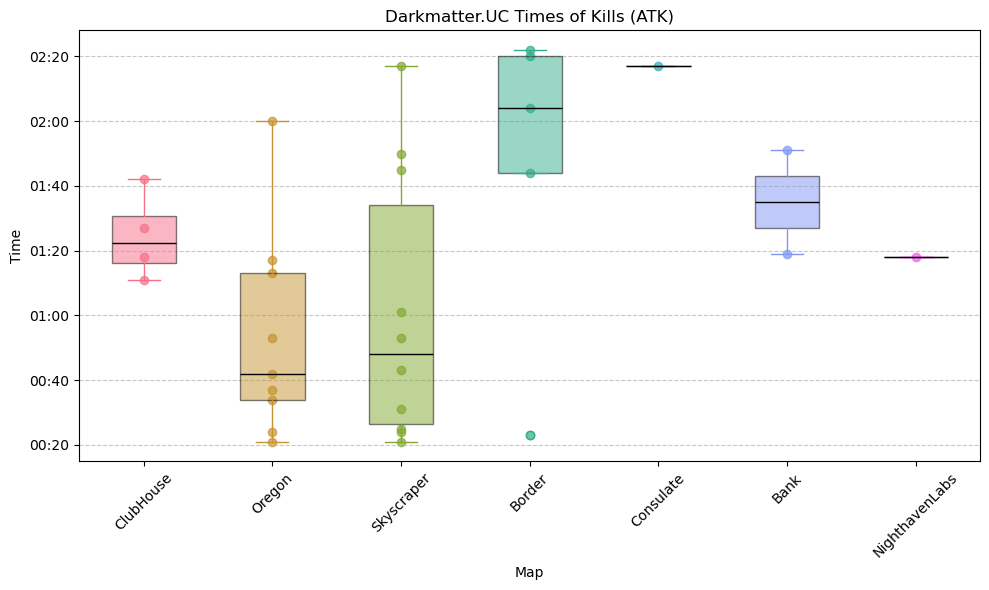

In [41]:
plot_scatter_with_boxplot(kill_times_atk, f"{player_name} Times of Kills (ATK)")

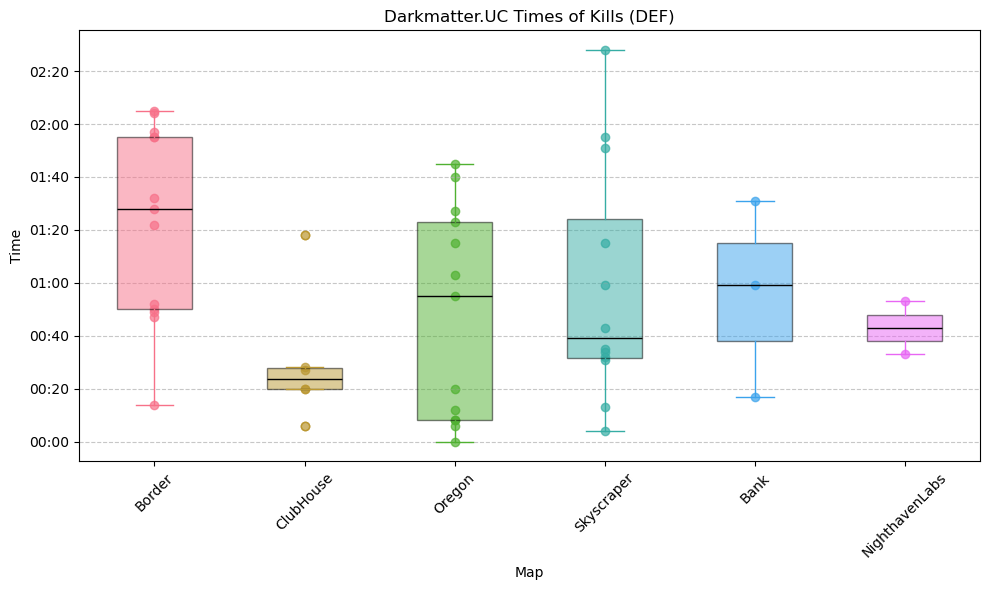

In [42]:
plot_scatter_with_boxplot(kill_times_def, f"{player_name} Times of Kills (DEF)")

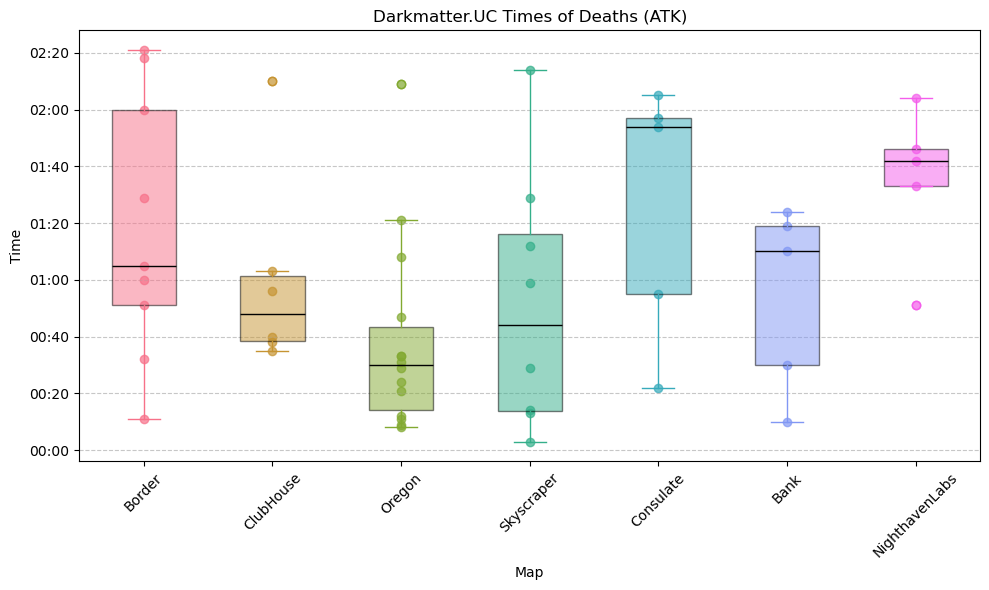

In [43]:
plot_scatter_with_boxplot(death_times_atk, f"{player_name} Times of Deaths (ATK)")

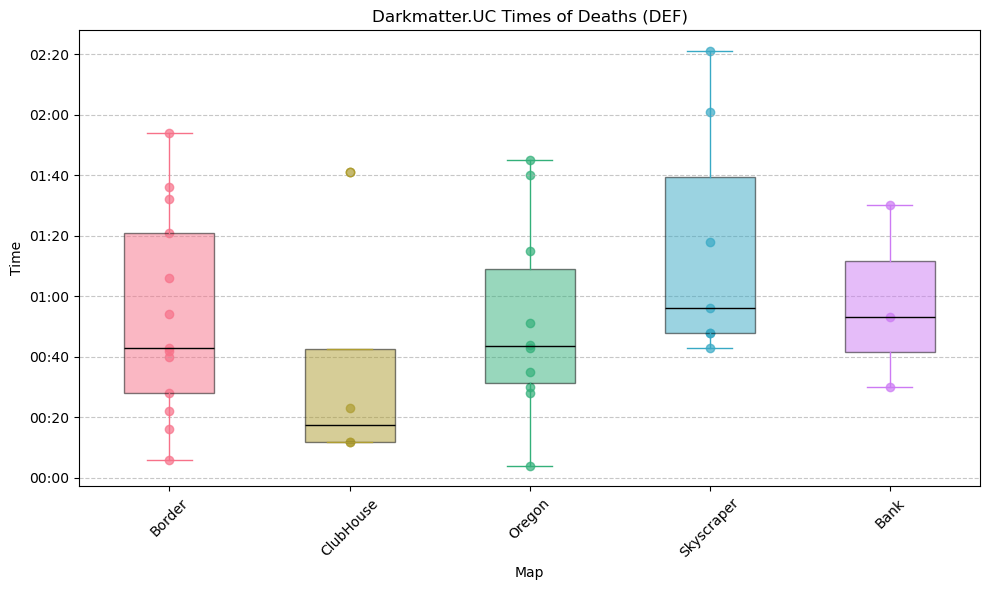

In [44]:
plot_scatter_with_boxplot(death_times_def, f"{player_name} Times of Deaths (DEF)")

# Engagement Efficiency

In [45]:
kill_df = pd.read_csv(DATA_DIR / "3_tables/kill_data.csv")
kill_df[(kill_df["killer_id"] == player_id) & (kill_df["map"] == "Skyscraper") & (kill_df["time_seconds"] > 140)]

,match_id,round_id,round_num,killer_id,victim_id,headshot,time,time_seconds,map,killer_operator,victim_operator,killer_side,victim_side,killer_spawn,victim_spawn,trade
1346,Match-2024-04-13_08-27-41-205,Match-2024-04-13_08-27-41-205_6,6,602ab4bc-8c6f-400a-a690-d0adc0cdbf58,724892ec-4bf4-4841-88dc-cc33a498bcca,False,2:28,148,Skyscraper,Kaid,Lion,Defense,Attack,"1F BBQ, 1F Kitchen",Ventilation Units,NOT YET IMPLEMENTED


In [46]:
def plot_engagements(x_labels, y_labels, heatmap_values, frequency_values, title, max_bullet_size=100):
    """
    Plots a heatmap with bullets overlaid, where:
    - The heatmap is colored from red (lowest values) to green (highest values).
    - The size of the bullet is proportional to the frequency values.
    - The frequency value is displayed on top of the bullet.

    Args:
    - x_labels (array-like): The labels for the x-axis (bins).
    - y_labels (array-like): The labels for the y-axis (bins).
    - heatmap_values (2D array-like): A 2D array of heatmap values.
    - frequency_values (2D array-like): A 2D array of frequency values, where each value determines the size of the bullet.
    - title (str): The title for the plot.
    - max_bullet_size (int): Maximum size of the bullets.
    """

    # Create the plot
    plt.figure(figsize=(8, 6))

    # Plot the heatmap with 'RdYlGn' colormap (red -> yellow -> green)
    plt.imshow(heatmap_values, cmap="RdYlGn", interpolation="nearest", aspect="auto", origin="lower")

    # Set axis labels
    plt.xticks(np.arange(len(x_labels)), x_labels, rotation=45)
    plt.yticks(np.arange(len(y_labels)), y_labels)

    # Normalize the frequency values for bullet size scaling
    norm_frequency = (frequency_values - frequency_values.min()) / (frequency_values.max() - frequency_values.min())  # Normalize frequency to [0, 1]
    bullet_sizes = norm_frequency * max_bullet_size  # Scale to the desired maximum bullet size

    # Ensure that the bullets are large enough to fit 3-digit numbers
    max_digits = 3  # Account for 3-digit numbers (100-999)
    bullet_min_size = 200  # Set a minimum bullet size to cover 3-digit text (this can be adjusted)

    bullet_sizes = np.maximum(bullet_sizes, bullet_min_size)  # Make sure no bullet is smaller than the minimum size

    # Overlay bullets using scatter plot (circle markers)
    x_positions, y_positions = np.meshgrid(np.arange(len(x_labels)), np.arange(len(y_labels)))  # Grid for positions
    scatter = plt.scatter(x_positions, y_positions, s=bullet_sizes.flatten(), c="black", alpha=0.5)  # Bullets overlaid

    # Add frequency value text on top of the bullets (cast to integer)
    for i in range(len(x_labels)):
        for j in range(len(y_labels)):
            frequency_text = str(int(frequency_values[j, i]))  # Cast frequency to integer for display
            plt.text(i, j, frequency_text, color="white", ha="center", va="center", fontsize=10)

    # Add titles and labels
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Map")

    plt.tight_layout()
    plt.show()

In [51]:
def get_engagements_plot_data(kill_data, player_id: str, side: str = "both", time_bin_size: int = 10):
    """
    Generates a heatmap of engagements for a specific map.

    Args:
    - kill_data (DataFrame): The DataFrame containing the kill data.
    - map_name (str): The name of the map to analyze.
    - time_bin_size (int): The size of the time bins in seconds.

    Returns:
    - x_labels (array-like): The labels for the x-axis (time bins).
    - y_labels (array-like): The labels for the y-axis (maps).
    - heatmap_values (2D array-like): A 2D array of heatmap values.
    - frequency_values (2D array-like): A 2D array of frequency values.
    """

    if side == "atk":
        side = "Attack"
    elif side == "def":
        side = "Defense"

    engagements_df = kill_data[(kill_data["killer_id"] == player_id) | (kill_data["victim_id"] == player_id)]
    if side != "both":
        engagements_df = engagements_df[
            ((engagements_df["killer_id"] == player_id) & (engagements_df["killer_side"] == side))
            | ((engagements_df["victim_id"] == player_id) & (engagements_df["victim_side"] == side))
        ]

    maps = sorted(engagements_df["map"].unique())

    # Define time bins (10-second intervals)
    time_bins = np.arange(0, 3 * 60, time_bin_size)  # 10-second time bins
    time_labels = [f"{seconds_to_mmss(time)}-{seconds_to_mmss(time + 10)}" for time in time_bins[:-1]]

    # Initialize heatmap and frequency data
    heatmap_data = np.zeros((len(maps), len(time_bins) - 1))
    frequency_data = np.zeros((len(maps), len(time_bins) - 1))

    # Loop over each map to fill the data
    for i, map_name in enumerate(maps):
        map_data = engagements_df[engagements_df["map"] == map_name]
        map_time_bins = pd.cut(map_data["time_seconds"], bins=time_bins, labels=False, right=False)
        heatmap_values, _ = np.histogram(map_time_bins, bins=range(len(time_bins)))
        frequency, _ = np.histogram(map_time_bins, bins=range(len(time_bins)))

        # Assign the values to the corresponding rows in the heatmap_data and frequency_data arrays
        heatmap_data[i] = heatmap_values
        frequency_data[i] = frequency

    # Flip the data horizontally (reverse the rows)
    heatmap_data = np.flip(heatmap_data, axis=1)
    frequency_data = np.flip(frequency_data, axis=1)
    time_labels = time_labels[::-1]

    return time_labels, maps, heatmap_data, frequency_data

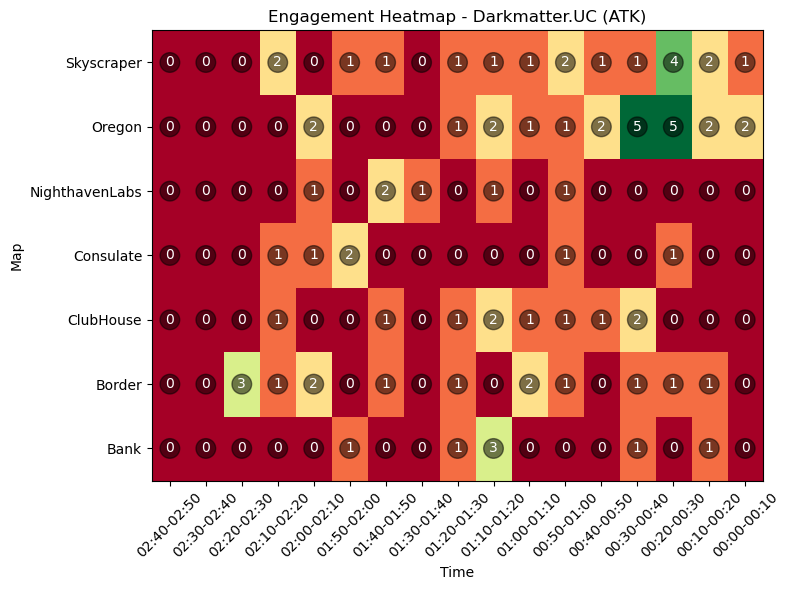

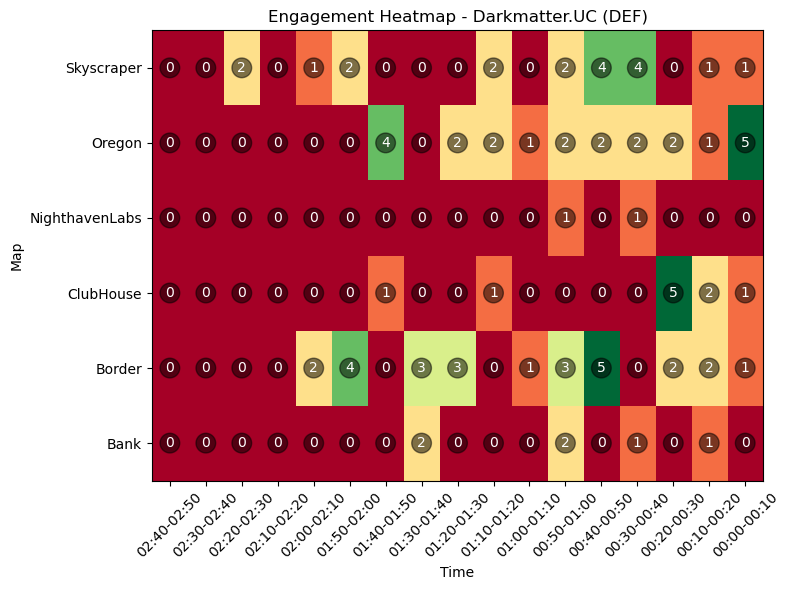

In [56]:
kill_df = pd.read_csv(DATA_DIR / "3_tables/kill_data.csv")

plot_engagements(*get_engagements_plot_data(kill_df, player_id, "atk"), f"Engagement Heatmap - {player_name} (ATK)", max_bullet_size=100)
plot_engagements(*get_engagements_plot_data(kill_df, player_id, "def"), f"Engagement Heatmap - {player_name} (DEF)", max_bullet_size=100)